In [1]:
from fastai.vision.all import *
import sklearn.metrics as skm
import pathlib
import glob

In [2]:
# Version
import fastai
fastai.__version__

'2.7.10'

In [4]:
# Load model
def get_multi_y(x): return parent_label(x).split("_")  # Original function that should be defined before loading the model
model = load_learner("output/20230102_trained-model.pkl")

# Load datasets
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   get_items = get_image_files,
                   get_y = get_multi_y,
                   splitter = GrandparentSplitter(train_name="train", valid_name="valid")
                   )

dls = dblock.dataloaders("training/high-pass")

In [5]:
# モデルの予測を格納するリストを作成
preds_class = []
preds_num = []
targs = []

# テストデータに対して予測を実行
for i, item in enumerate(dls.valid.items):
    # model prediction
    pred_class, _, pred_num = model.predict(item)
    
    preds_class.append(pred_class)
    preds_num.append(pred_num.numpy())
    
    targs.append(dls.valid_ds[i][1].numpy())

予測とラベル、そして対応するファイル名をcsvとして書き出す。

In [6]:
# 扱いやすいようにlistをnumpy.ndarrayに変換
preds_num = np.array(preds_num)
targs = np.array(targs)

In [7]:
print(skm.classification_report(targs, preds_num>0.5, target_names=dls.vocab))

              precision    recall  f1-score   support

        Bjap       1.00      0.90      0.95        40
        Djap       0.95      0.93      0.94        40
        Grug       0.91      0.80      0.85        40
        Pnig       0.91      0.75      0.82        40
        Zsch       1.00      0.97      0.99        40
  background       0.75      1.00      0.86        40

   micro avg       0.91      0.89      0.90       240
   macro avg       0.92      0.89      0.90       240
weighted avg       0.92      0.89      0.90       240
 samples avg       0.91      0.90      0.90       240



C:\Users\kburo\anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 結果の保存

In [ ]:
# まず予測とラベルの一覧を書き出す
preds_df = pd.DataFrame({
    "file": [o.name for o in dls.valid.items],
    "preds": ["_".join(classes) for classes in preds_class],
    "label": [o.parent.name for o in dls.valid.items]
})

preds_df.to_csv("output/validation-results.csv")  # check OK

In [ ]:
# 続いてmetricsを書き出す

metrics = skm.classification_report(targs[:,:5], preds_num[:,:5]>0.5, 
                          target_names=dls.vocab[:5], output_dict=True)

metrics_df = pd.DataFrame(metrics)

metrics_df.to_csv("output/metrics-results.csv")  # check OK

## 間違いの詳細を調べる

In [ ]:
# 予測値がない行をnoneで埋めて（でないとエラーが出る)、文字列を＿で分割し、abc順にソートする
preds_list = preds_df["preds"].fillna("none").str.split("_").apply(sorted)
preds_list

In [ ]:
labels_list = preds_df["label"].str.split("_").apply(sorted)

In [ ]:
preds_df[preds_list != labels_list].to_csv("output/misclassified.csv", index=False)   # 予測値とラベルがマッチしない行を抽出して保存

190枚のスペクトログラムのうち34枚（17.9%）が完答ではなかったようだ（output/misclassified.csv）を確認。気づいたこととしては

- 意外なことに、特に多い間違いはDjapやGrugの単体。どちらも10枚中6枚で間違い。backgroundや混声と予測されている。単体鳴きのときは鳴き声が弱い場合が多いことも関係していそうだ。
- 3種混声は半分（10枚中5枚）で間違い。Djapは必ず検出されているが、Pnigが抜けることが4回、Grugが抜けるのが1回。妥当だと思う。

- backgroundと予測してしまったBjapは、3枚すべてほんの短く小さく鳴くものだった。
- Bjap+Zschは5枚中1枚だけ間違えていて、Zschのみ検出されている。もとの画像を見ても特別Bjapの鳴き声が小さいわけではないので、なぜ間違えたかはよくわからない。



## Precision-recall curveを見る

トノサマやツチはrecallが低いのだが、それは閾値を変更することで改善するのか、precision-recall curveによって確かめる。

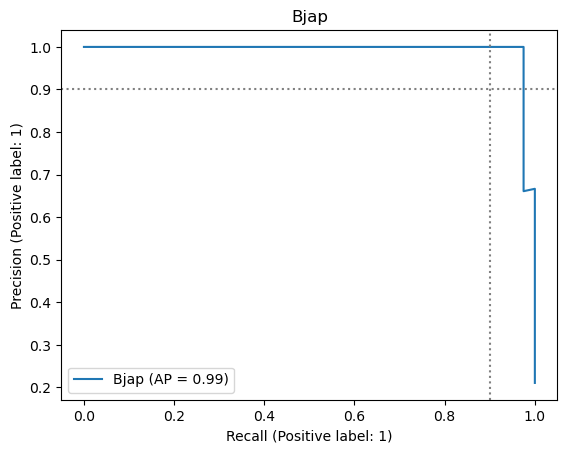

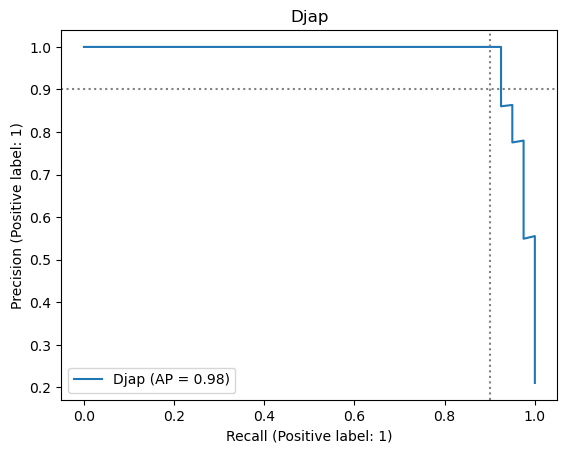

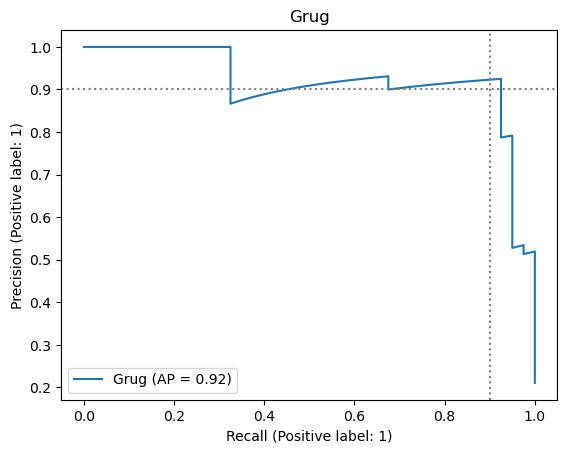

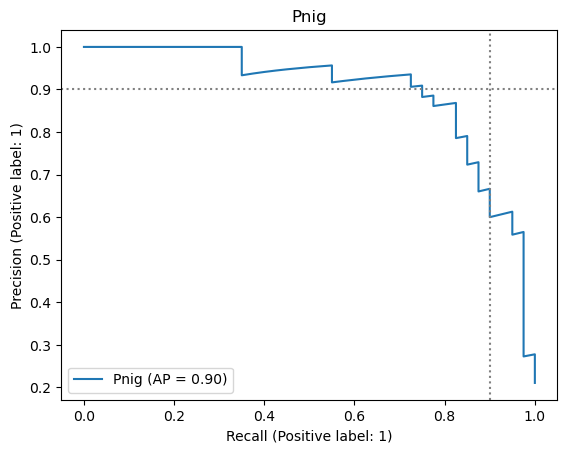

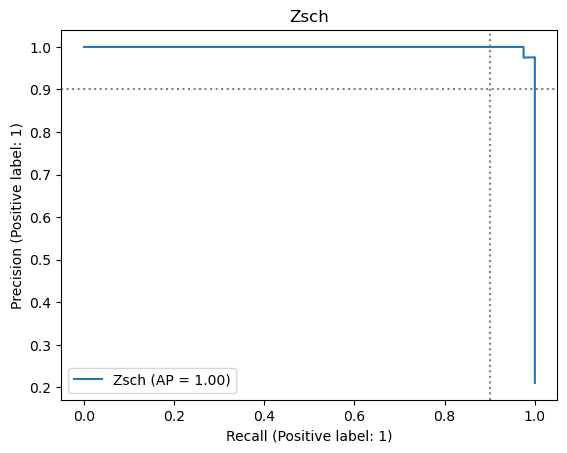

In [47]:
for i, sp in enumerate(["Bjap", "Djap", "Grug", "Pnig", "Zsch"]):
    skm.PrecisionRecallDisplay.from_predictions(targs[:,i], preds_num[:,i], name = sp, drawstyle="default")
    plt.axvline(0.9, color="gray", linestyle="dotted")
    plt.axhline(0.9, color="gray", linestyle="dotted")
    plt.title(sp)
    plt.show()

ツチガエルの場合は閾値をうまく設定することで、precision, recallともに0.9を超えることができそうだ。しかしトノサマの場合はそうはいかなくて、recallを90％以上にしようとすると、precisionは60％以下に下がってしまう。